## This notebook is for the actual random forest model I am using to predict values of my TTT index

In [122]:
# IMPORTS
import numpy as np
import pandas as pd
import datetime as dt
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

#set matplotlib parameters here
mpl.rcParams['savefig.dpi'] = 350
mpl.rcParams['savefig.facecolor'] = 'white'
mpl.rcParams['savefig.bbox'] = 'tight'

#figure path goes here
figure_path = os.getcwd() + '/FIGURES/'


In [123]:
# SET GLOBAL PARAMETERS HERE
split_size = 0.2
number_of_trees = 50
tree_depth = None
node_split = 5
leaf_samples = 2
criterion = 'gini'
RANDNUM = 144

## Now let's bring in our processed data

In [124]:
#read in data from our CSV
features = pd.read_csv(os.getcwd() + '/DATA/TTT_CLASSIFY.csv')
#remove any nans from the dataset

In [125]:
#display the first few rows
print(f'Feature Shape Is: {features.shape}')
features.head(5)

Feature Shape Is: (1958, 20)


,DOY,YEAR,MONTH,DAY,TTT_INDEX_VAL,TTT_INDEX_VAL_1D,TTT_INDEX_CLIM,TTT_DAY_BOOL,OMI_AMP,OMI_PHASE,Q850,Z200_B1,Z200_B2,U850,V850_B1,V850_B2,SURF_PRES_B1,SURF_PRES_B2,W500,RAND_VAR
0,12.0,2000,1,12,-23.031,35.557,2.509023,0.0,2.66665,1.0,0.000921,209.058968,-305.519169,1.392385,2.823147,7.550255,-629.294361,959.369781,-0.033304,16
1,9.0,2013,1,9,-23.041,-23.031,-4.613023,0.0,0.97518,1.0,0.000194,932.644651,-121.337993,1.551458,-5.990872,-8.082522,88.155162,-712.102689,0.057545,85
2,123.0,1992,5,3,-3.409,-23.041,-1.352568,0.0,2.06804,8.0,-0.001346,-605.819335,-3186.127459,2.829781,-3.113409,-7.194403,-1549.197816,-1513.413671,0.058884,41
3,29.0,2000,1,29,17.534,-3.409,1.237977,0.0,3.11747,4.0,-0.000317,234.677033,-1557.889812,2.637203,-2.866826,0.339527,-104.075109,-480.669426,0.014963,21
4,80.0,1989,3,21,-11.714,17.534,0.048955,0.0,1.28347,6.0,-0.001077,244.107437,-225.111252,-1.507053,-0.551635,0.604287,-182.770902,62.248547,0.028643,39


In [126]:
features.describe()

,DOY,YEAR,MONTH,DAY,TTT_INDEX_VAL,TTT_INDEX_VAL_1D,TTT_INDEX_CLIM,TTT_DAY_BOOL,OMI_AMP,OMI_PHASE,Q850,Z200_B1,Z200_B2,U850,V850_B1,V850_B2,SURF_PRES_B1,SURF_PRES_B2,W500,RAND_VAR
count,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000
mean,165.332993,2000.550051,5.941777,15.764556,2.833206,2.833206,0.368501,0.090909,1.235113,4.472421,0.000095,24.507481,-21.747333,0.105027,-0.194239,0.113103,-24.794990,9.369050,-0.006167,48.258427
std,123.314651,12.710056,4.031390,8.806860,17.475920,17.475920,1.498203,0.287553,0.675031,2.278738,0.001121,663.873182,896.163277,1.516105,2.875810,5.563333,689.492111,630.528688,0.054971,29.245784
min,1.000000,1979.000000,1.000000,1.000000,-44.755000,-44.755000,-4.613023,0.000000,0.028710,1.000000,-0.004044,-2646.962192,-3237.858995,-5.378351,-8.863284,-17.571197,-2545.660914,-2424.406647,-0.271815,0.000000
25%,61.250000,1989.000000,3.000000,8.000000,-8.603500,-8.603500,-0.539256,0.000000,0.705048,2.000000,-0.000704,-402.046431,-612.859595,-0.902877,-2.174423,-3.719621,-454.713228,-394.989297,-0.033473,22.250000
50%,119.000000,2001.000000,4.000000,16.000000,0.143000,0.143000,0.317341,0.000000,1.145995,4.000000,0.000080,51.026330,11.844378,0.095740,-0.308143,0.234244,23.185436,43.984753,0.001706,48.000000
75%,303.000000,2011.000000,10.000000,23.000000,12.870000,12.870000,1.346568,0.000000,1.680305,6.000000,0.000893,482.933816,567.911939,1.098723,1.708614,4.024919,443.995975,427.139275,0.029695,73.000000
max,365.000000,2022.000000,12.000000,31.000000,55.349000,55.349000,5.192727,1.000000,3.697050,8.000000,0.003217,2179.985488,2776.132402,7.238969,9.051256,17.761133,2051.635346,2143.690586,0.129390,99.000000


In [127]:
'''
    Use These if I want to predict relative to a threshold/classify
'''
THRESHOLD_VAL = 30.04187752610973
TARGET_VAR = "TTT_INDEX_VAL"
labels = np.array(features[TARGET_VAR] > THRESHOLD_VAL).astype(int)
label_names = ("No TTT","TTT")

features = features.drop(TARGET_VAR,axis = 1)
features = features.drop("TTT_DAY_BOOL",axis = 1)
features = features.drop('YEAR',axis = 1)
features = features.drop('DAY',axis = 1)
features = features.drop('DOY',axis = 1)
feature_list = list(features.columns)
features = np.array(features)

classes = ['No TTT','TTT']


In [128]:
# split the data into training and testing sets
train_features,test_features, train_labels, test_labels = train_test_split(features,labels,test_size = split_size,random_state=RANDNUM)

### Now we can work on training/testing our model

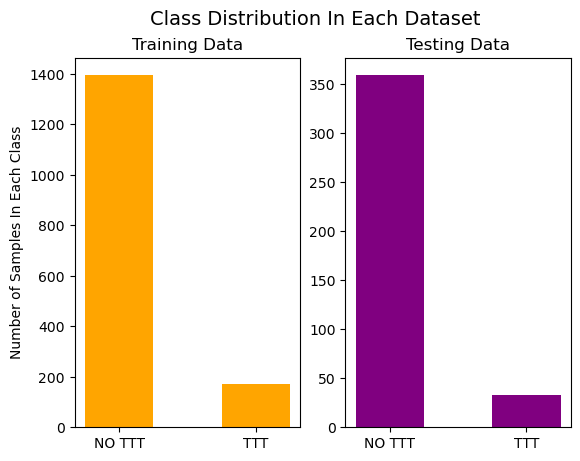

In [129]:
#let's look at our class distribution first
fig,ax = plt.subplots(1,2,sharex=True)
ax[0].hist(train_labels,bins = [-0.25,0.25,0.75,1.25],rwidth = 1,color = 'orange')
ax[0].set_xticks([0,1],['NO TTT','TTT'])
ax[0].set_ylabel('Number of Samples In Each Class')
ax[0].set_title('Training Data')

ax[1].hist(test_labels,color = 'purple',bins = [-0.25,0.25,0.75,1.25])
ax[1].set_title('Testing Data')

plt.suptitle('Class Distribution In Each Dataset',fontsize = 14)

plt.savefig(figure_path + 'CLASS_DISTRIBUTION.PNG')

In [130]:
#instantiate the model
rf = RandomForestClassifier(n_estimators=number_of_trees,
                           random_state= RANDNUM,
                           min_samples_split= node_split,
                           min_samples_leaf = leaf_samples,
                           criterion = criterion,
                           max_depth = tree_depth)

# Train the model on the training data
rf.fit(train_features,train_labels)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, n_estimators=50,
                       random_state=144)

In [131]:
#now let's make predictions
test_predictions = rf.predict(test_features)
train_predictions = rf.predict(train_features)


In [132]:
#let's look at the confusion matrix
acc = metrics.accuracy_score(train_labels,train_predictions)
print('Training Accuracy: ',np.round(acc*100), '%')
acc = metrics.accuracy_score(test_labels, test_predictions)
print("Testing Accuracy: ", np.around(acc*100), '%')


Training Accuracy:  99.0 %
Testing Accuracy:  99.0 %


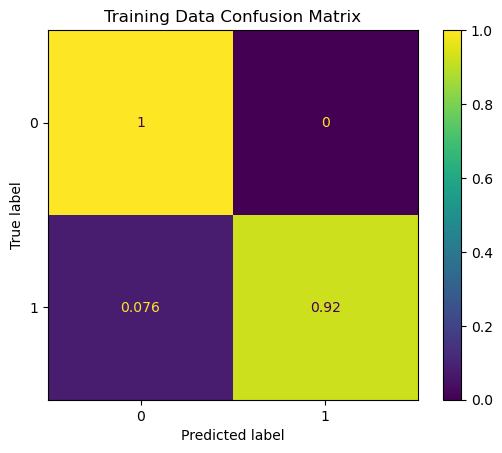

In [133]:
ConfusionMatrixDisplay.from_predictions(train_labels, train_predictions, normalize="true")
plt.title("Training Data Confusion Matrix")

plt.savefig(figure_path + 'TRAINING_CONFUSION_MATRIX.PNG')

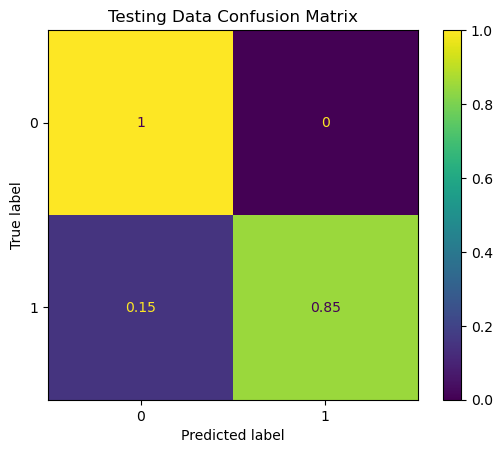

In [134]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, normalize="true")
plt.title("Testing Data Confusion Matrix")

plt.savefig(figure_path + 'TESTING_CONFUSION_MATRIX.PNG')

In [135]:
# now let's look at feature importances
def sort_list(list1, list2):
 
    zipped_pairs = zip(list2, list1)
 
    z = [x for _, x in sorted(zipped_pairs)]
 
    return z

def calc_importances(rf, feature_list):

    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

    return importances

def plot_feat_importances(importances, feature_list): 
    plt.figure()
    #sort the importances/feature list together
    feature_list = sort_list(feature_list,importances)
    importances = sorted(importances)
    # Set the style
    #plt.style.use('fivethirtyeight')
    # list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart
    plt.barh(x_values, importances,zorder = 2, color = 'purple')
    # Tick labels for x axis
    plt.yticks(x_values, feature_list)
    # Axis labels and title
    plt.xlabel('Importance'); plt.title('Variable Importances',fontsize = 14)
    plt.grid(color = 'k',alpha = 0.2,zorder = -1)

    plt.savefig(figure_path + 'VAR_IMPORTANCE.PNG')

    plt.show()

Variable: TTT_INDEX_VAL_1D     Importance: 0.53
Variable: W500                 Importance: 0.13
Variable: Q850                 Importance: 0.08
Variable: V850_B1              Importance: 0.05
Variable: TTT_INDEX_CLIM       Importance: 0.03
Variable: U850                 Importance: 0.03
Variable: MONTH                Importance: 0.02
Variable: Z200_B1              Importance: 0.02
Variable: Z200_B2              Importance: 0.02
Variable: V850_B2              Importance: 0.02
Variable: SURF_PRES_B2         Importance: 0.02
Variable: OMI_AMP              Importance: 0.01
Variable: OMI_PHASE            Importance: 0.01
Variable: SURF_PRES_B1         Importance: 0.01
Variable: RAND_VAR             Importance: 0.01


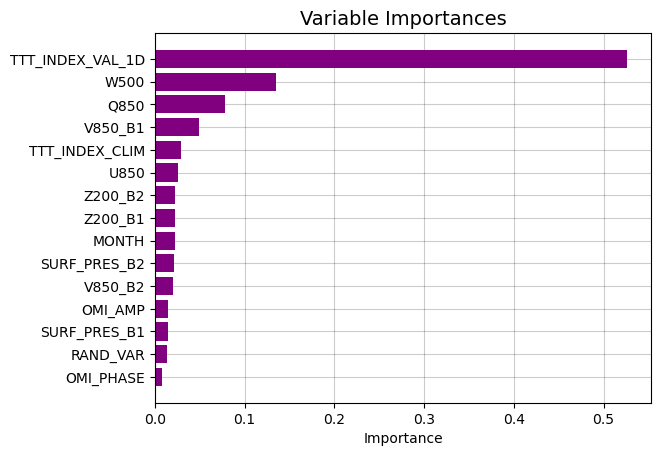

In [136]:
plot_feat_importances(calc_importances(rf, feature_list), feature_list)

In [137]:
# Single-pass permutation
permute = permutation_importance(rf, test_features, test_labels, n_repeats=10, 
                                 random_state=42)

# Sort the importances
sorted_idx = permute.importances_mean.argsort()

In [138]:
def plot_perm_importances(permute, sorted_idx, feature_list, set_name):
  # Sort the feature list based on 

    new_feature_list = []
    for index in sorted_idx:  
        new_feature_list.append(feature_list[index])

    fig, ax = plt.subplots()
    ax.boxplot(permute.importances[sorted_idx].T,
           vert=False, labels=new_feature_list)
    ax.set_title(f"Permutation Importances ({set_name})")
    fig.tight_layout()

    plt.savefig(figure_path + f"{set_name}_PERM_IMPORTANCE.PNG")

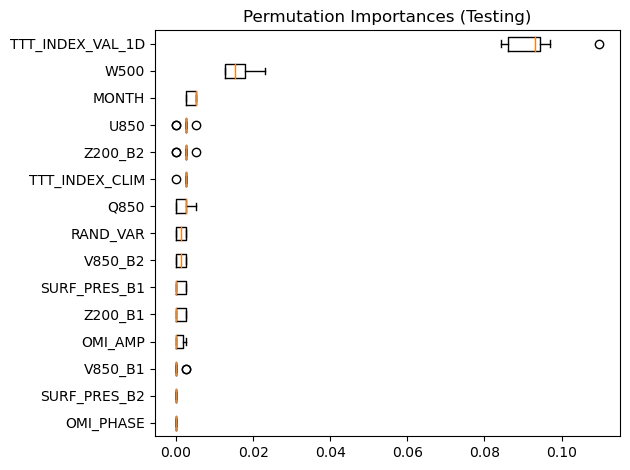

In [139]:
plot_perm_importances(permute, sorted_idx, feature_list, 'Testing')

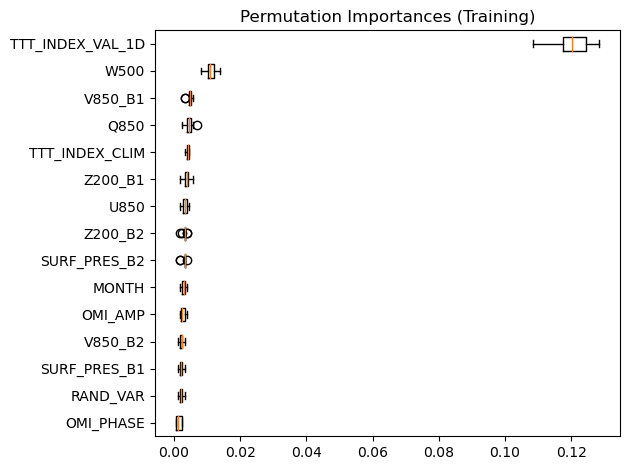

In [140]:
permute = permutation_importance(rf, train_features, train_labels, n_repeats=10, random_state=42)
sorted_idx = permute.importances_mean.argsort()

plot_perm_importances(permute, sorted_idx, feature_list,'Training')

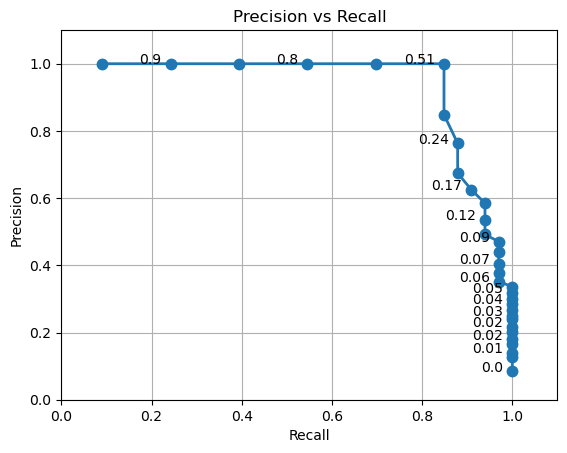

In [141]:
# precision/recall plots
step = 5
y_probs = rf.predict_proba(test_features)
y_scores = y_probs[:, 1]
precisions, recalls, thresholds = precision_recall_curve(test_labels, y_scores)
plt.plot(recalls[::step], precisions[::step], linewidth=2, linestyle="-", marker=".", markersize=15, label="Precision/Recall curve")
for i in np.arange(0, len(thresholds), step*2):
    plt.text(recalls[i]-.02, precisions[i], thresholds[i].round(2), ha="right")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1.1, 0, 1.1])
plt.title("Precision vs Recall")
plt.grid()
